In [1]:
import xarray as xr 
import matplotlib.pyplot as plt
import numpy as np
from thesis_toolbox.process_era5 import resample_seasonal
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import os
import matplotlib as mpl
from thesis_toolbox.plot.tools import add_letter
from thesis_toolbox.utils import get_locations_CLP, load_MERRA2_seasonal, create_deposition_timeseries_MERRA2
import dask
from functools import partial
import glob
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#5790fc", "#f89c20", "#e42536", "#964a8b", "#9c9ca1", "#7a21dd"])
%matplotlib inline

In [2]:
def std_scale(df):
    return (df-df.mean(axis=0))/df.std(axis=0)


In [3]:
def min_max(df):
    return (df-df.min(axis=0))/(df.max(axis=0)-df.min(axis=0))

In [4]:
site_color_dict = {'SHAPOTOU':'#6c16cc', 'SACOL':'#5790fc', 'LANTIAN':'#f89c20', 
                   'LINGTAI':'#9c9ca1', 'LUOCHUAN':'#ba5bac', 'BAODE':'#c41020'}

df_flexpart = pd.read_csv('../../data/data/results/timeseries_table.csv', index_col=0)

In [5]:
ds = xr.open_mfdataset('../../data/MERRA2/dust/*.nc4', concat_dim=['time'], combine='nested')

In [6]:
def load_MERRA_at_station(ds, location, wetdep_field='DUWT002', drydep_field='DUDP002', season='MAM'):
    locs = get_locations_CLP()
#     locs = locs.rename({'BADOE':'BAODE'}, axis=0)
    out_ds = xr.Dataset()
    sec_in_month=2592000
    lon = locs.loc[location,'lon']
    lat = locs.loc[location,'lat']
    depo_fields = [wetdep_field, drydep_field]
    for merra_name,kind in zip(depo_fields,['wetdep','drydep']):
        temp = ds.copy()
        temp = temp.rename({merra_name:kind})
        temp = temp.interp(lon=lon, lat=lat,method='linear')
#         print(ds.dims)
        temp=temp.resample(time='Q-NOV').sum(keep_attrs=True)
        temp=temp.sel(time=(temp.time.dt.season==season))
        out_ds[f'{kind} {location}'] = temp[kind]*1000*sec_in_month*3
    df = out_ds.to_dataframe()
    df = df.drop(['lon','lat'],axis=1)
    df[f'total {location}'] = df[f'drydep {location}'] + df[f'wetdep {location}']
    return df
    

In [7]:
df_SACOL = load_MERRA_at_station(ds,'SACOL',
                               wetdep_field='DUWT002',drydep_field='DUDP002')
df_BAODE = load_MERRA_at_station(ds, 'BAODE',
                               wetdep_field='DUWT002',drydep_field='DUDP002')
df_LANTIAN = load_MERRA_at_station(ds,'LANTIAN',
                                 wetdep_field='DUWT002',drydep_field='DUDP002')
df_SHAPOTOU = load_MERRA_at_station(ds, 'SHAPOTOU',
                                  wetdep_field='DUWT002',drydep_field='DUDP002')
df_LINGTAI = load_MERRA_at_station(ds, 'LINGTAI',
                                 wetdep_field='DUWT002',drydep_field='DUDP002')
df_LUOCHUAN = load_MERRA_at_station(ds, 'LUOCHUAN',
                                  wetdep_field='DUWT002',drydep_field='DUDP002')

In [8]:
df= df_SHAPOTOU.join([df_BAODE,df_SACOL,df_LUOCHUAN, df_LANTIAN,df_LINGTAI])

locations =  ['SHAPOTOU','SACOL','LANTIAN','LINGTAI','LUOCHUAN','BAODE']
df_flexpart_wetdep = df_flexpart[[f'total {site} wetdep 2micron' for site in locations]]
df_flexpart_drydep = df_flexpart[[f'total {site} drydep 2micron' for site in locations]]
df_depo_flexpart = df_flexpart_drydep.join(df_flexpart_wetdep)

df_depo_flexpart[[f'{site} total 2micron' for site in locations]] = df_flexpart_wetdep.values + df_flexpart_drydep.values

sites_merra = ['SHAPOTOU','SACOL','LANTIAN','LINGTAI','LUOCHUAN', 'BAODE']

df.index = df_depo_flexpart.index

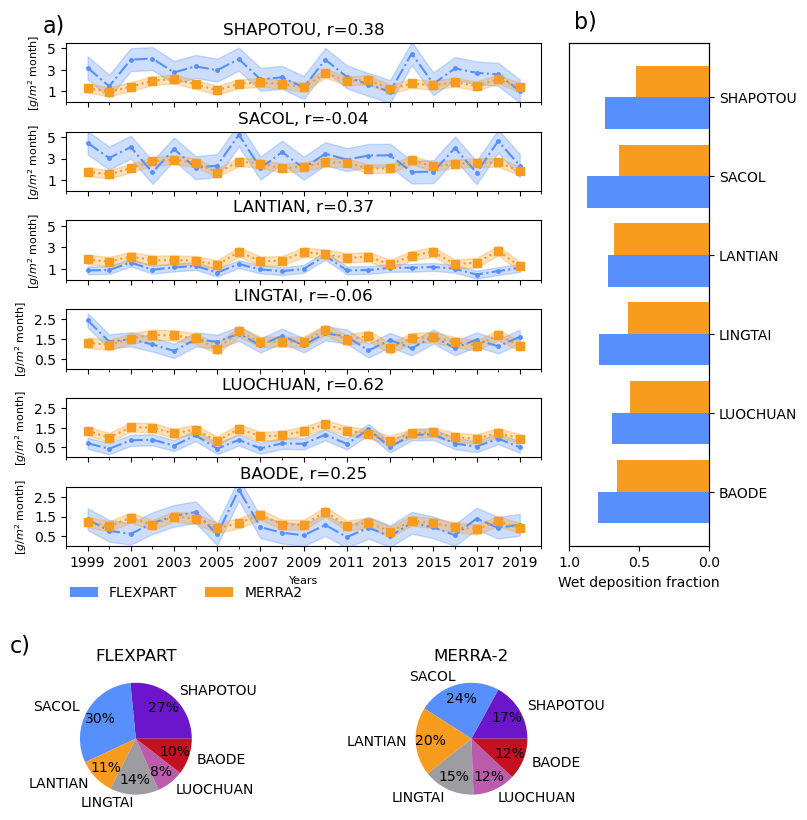

In [9]:

df_tot_merra = df[[f'total {site}' for site in sites_merra]]
df_tot_flexpart  =df_depo_flexpart[[f'{site} total 2micron' for site in locations]]
markers = ['.','s']

frac_wetdep_flexpart=pd.DataFrame(df_depo_flexpart[[f'total {site} wetdep 2micron' for site in locations]].values/df_tot_flexpart.values,index=df_depo_flexpart.index,
             columns=['{} frac wetdep'.format(site) for site in locations]).mean()

frac_wetdep_merra = pd.DataFrame(df[[f'wetdep {site}' for site in sites_merra]].values/df_tot_merra.values, index=df_tot_merra.index, 
                                    columns=['{} frac wetdep'.format(site) for site in sites_merra]).mean()

# df_tot_merra = std_scale(df_tot_merra)
# df_tot_flexpart = std_scale(df_tot_flexpart)
color=["#5790fc", "#f89c20", "#e42536", "#964a8b", "#9c9ca1", "#7a21dd"]
fig= plt.figure(figsize=(8.3,10))
gs = fig.add_gridspec(9, 4,hspace=0.5,wspace=0.2)
index=0
plt.rc('axes', labelsize=8)
axes = []
ax = fig.add_subplot(gs[index,:3])
ax.set_xticks(df_depo_flexpart.index[::2])

ax.xaxis.set_minor_locator(MultipleLocator(2))

axes.append(ax)
for merra,flexpart in zip(df_tot_merra.items(), df_tot_flexpart.items()):
    if index > 0:
        ax = fig.add_subplot(gs[index,:3], sharex=ax)
#     ax_1 = ax.twinx()
#     ax.set_xticks(df_depo_flexpart.index[::2])
    flexpart[1].plot(ax=ax, marker='o', linestyle='-.', color="#5790fc",markersize=2.5)
    ax.fill_between(flexpart[1].index, flexpart[1].std()+flexpart[1], flexpart[1]-flexpart[1].std(),alpha=.3,color="#5790fc")
    merra[1].plot(ax=ax,marker='s', linestyle=':', color="#f89c20")
    ax.fill_between(merra[1].index, merra[1].std()+merra[1], merra[1]-merra[1].std(),alpha=.3,color="#f89c20")
    corr = flexpart[1].corr(merra[1])
    ax.set_title(f'{merra[0].split(" ")[1]}, r={corr:.2f}')
    index+=1
    ax.set_ylabel('[$g/m^2 \; \mathrm{month}$]')
#     ax_1.set_ylabel('MERRA2')
    if index > 3:
        ax.set_ylim(0,3)
        ax.set_yticks([0.5,1.5,2.5])

    else:
        ax.set_ylim(0,5.5)
        ax.set_yticks([1,3,5])
ax.set_xticklabels([str(l) for l in df_depo_flexpart.index[::2]])
plt.setp(ax.xaxis.get_label(), visible=True, text='Years')

ax = fig.add_subplot(gs[:6,3])
x=np.arange(1,len(frac_wetdep_flexpart)+1)
# ax.invert_yaxis()
ax.set_yticklabels([]) # Hide the left y-axis tick-labels
ax.set_yticks([]) # Hide the left y-axis ticks
ax1 = ax.twinx() # Create a twin x-axis
ax1.barh(x, frac_wetdep_flexpart.values[::-1], height=0.4, color="#5790fc", label='FLEXPART')
ax1.barh(x+0.4, frac_wetdep_merra.values[::-1], height=0.4, color="#f89c20",label='MERRA2')
# ax.barh
# ax.yaxis.set_ticks_position('left')
ax.set_xlim(1,0)
ax1.set_yticks(x+0.2)
ax1.set_yticklabels(sites_merra[::-1])
h,l = ax1.get_legend_handles_labels()
fig.legend(h,l,bbox_to_anchor=(0.27,0.33), frameon=False,loc=10, ncol=2)
# axes.append(ax)

mean_dep_fp=df_depo_flexpart.mean(axis=0)[[f'{site} total 2micron' for site in locations]]

mean_dep_merra = df.mean(axis=0)[[f'total {site}' for site in sites_merra]]


ax_p1 = fig.add_subplot(gs[7:,:1])

ax_p2 = fig.add_subplot(gs[7:,2:3])

mean_dep_fp = mean_dep_fp.rename({
    k: k.split(' ')[0] for k in mean_dep_fp.keys()})

mean_dep_merra = mean_dep_merra.rename({
    k: k.split(' ')[-1] for k in mean_dep_merra.keys()})


df_color_fp = mean_dep_fp.index.map(site_color_dict)

df_color_merra = mean_dep_merra.index.map(site_color_dict)
mean_dep_fp.plot.pie(ax=ax_p1,colors=df_color_fp,pctdistance=.74, autopct='%1.0f%%',label='',labeldistance=1.15, title=
                      'FLEXPART')
mean_dep_merra.plot.pie(ax=ax_p2,colors=df_color_fp,pctdistance=.74, autopct='%1.0f%%',label='',labeldistance=1.15, title=

                        'MERRA-2')
# ax_p1.text(0.04,0.9, '')
add_letter(np.array(axes),y=1.18,x=-0.05,zorder=4000)
ax.text(0.03, 1.03,'b)',transform=ax.transAxes, fontsize=16)
ax.set_xlabel('Wet deposition fraction', fontsize=10)
# axes[0].set_xticks(df_depo_flexpart.index[::2])
# axes[0].xaxis.set_minor_locator(MultipleLocator(2))
ax_p1.text(-0.4, 1.12,'c)',transform=ax_p1.transAxes, fontsize=16)

ax = fig.get_axes()[0]
# ax.xaxis.set_ticklabels([(pos,str(i)) for i, pos in zip(df_depo_flexpart.index[::2],ax.get_xticks())])

# plt.setp(, visible=True, text='years')
plt.savefig('FLEXPART_MERRA2_total_depostion_clay.pdf', bbox_inches='tight')
plt.savefig('FLEXPART_MERRA2_total_depostion_clay.png',dpi=300, bbox_inches='tight')

In [10]:
df_wetdep_merra = df[[f'wetdep {site}' for site in sites_merra]]
df_wetdep_flexpart =df_depo_flexpart[[f'total {site} wetdep 2micron' for site in locations]]
df_drydep_merra = df[[f'drydep {site}' for site in sites_merra]]
df_drydep_flexpart =df_depo_flexpart[[f'total {site} drydep 2micron' for site in locations]]
markers = ['.','s']

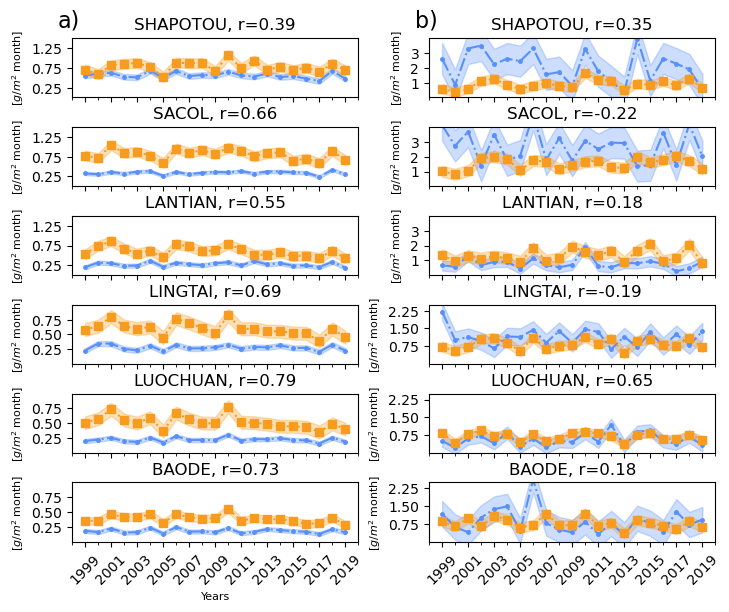

In [11]:

color=["#5790fc", "#f89c20", "#e42536", "#964a8b", "#9c9ca1", "#7a21dd"]
fig= plt.figure(figsize=(8.3,10))
gs = fig.add_gridspec(9, 5,hspace=0.5,wspace=0.2, width_ratios=[1,1,0.2,1,1])
index=0
plt.rc('axes', labelsize=8)
axes = []
ax = fig.add_subplot(gs[index,:2])


axes.append(ax)
for merra,flexpart in zip(df_drydep_merra.items(), df_drydep_flexpart.items()):
    if index > 0:
        ax = fig.add_subplot(gs[index,:2])

    flexpart[1].plot(ax=ax, marker='o', linestyle='-.', color="#5790fc",markersize=2.5)
    ax.fill_between(flexpart[1].index, flexpart[1].std()+flexpart[1], flexpart[1]-flexpart[1].std(),alpha=.3,color="#5790fc")
    merra[1].plot(ax=ax,marker='s', linestyle=':', color="#f89c20")
    ax.fill_between(merra[1].index, merra[1].std()+merra[1], merra[1]-merra[1].std(),alpha=.3,color="#f89c20")
    corr = flexpart[1].corr(merra[1])
    ax.set_title(f'{merra[0].split(" ")[1]}, r={corr:.2f}')
    index+=1
    ax.set_ylabel('[$g/m^2 \; \mathrm{month}$]')

    if index > 3:
        ax.set_ylim(0,1)
        ax.set_yticks([0.25,.5,.75])

    else:
        ax.set_ylim(0,1.5)
        ax.set_yticks([0.25,.75,1.25])
    ax.set_xticks(df_depo_flexpart.index[::2])

    ax.xaxis.set_minor_locator(MultipleLocator(2))
    ax.set_xticklabels([],rotation=45)
ax.set_xticklabels([str(l) for l in df_depo_flexpart.index[::2]],rotation=45)
plt.setp(ax.xaxis.get_label(), visible=True, text='Years')
index=0

ax1 = fig.add_subplot(gs[index,3:])
ax1.set_xticks(df_depo_flexpart.index[::2])



axes.append(ax1)
for merra,flexpart in zip(df_wetdep_merra.items(), df_wetdep_flexpart.items()):
    if index > 0:
        ax1 = fig.add_subplot(gs[index,3:])

    flexpart[1].plot(ax=ax1, marker='o', linestyle='-.', color="#5790fc",markersize=2.5)
    ax1.fill_between(flexpart[1].index, flexpart[1].std()+flexpart[1], flexpart[1]-flexpart[1].std(),alpha=.3,color="#5790fc")
    merra[1].plot(ax=ax1,marker='s', linestyle=':', color="#f89c20")
    ax1.fill_between(merra[1].index, merra[1].std()+merra[1], merra[1]-merra[1].std(),alpha=.3,color="#f89c20")
    corr = flexpart[1].corr(merra[1])
    ax1.set_title(f'{merra[0].split(" ")[1]}, r={corr:.2f}')
    index+=1
    ax1.set_ylabel('[$g/m^2 \; \mathrm{month}$]')

    if index > 3:
        ax1.set_ylim(0,2.5)
        ax1.set_yticks([0.75,1.5,2.25])

    else:
        ax1.set_ylim(0,4)
        ax1.set_yticks([1,2,3])
    ax1.set_xticks(df_depo_flexpart.index[::2])
    ax1.set_xticklabels([])
    ax1.xaxis.set_minor_locator(MultipleLocator(2))
fig.axes[-1].xaxis.set_ticklabels([str(l) for l in df_depo_flexpart.index[::2]],rotation=45)
# plt.setp(ax1.xaxis.get_label(), visible=True, text='Years')
# plt.setp(ax1.xaxis.get_label(), visible=True, text='Years')

# fig.axes[-1].xaxis.get_ticklabels()
add_letter(np.array(axes),y=1.18,x=-0.05,zorder=4000)
plt.savefig('FLEXPART_MERRA2_wetdry_depostion_clay.pdf', bbox_inches='tight')
plt.savefig('FLEXPART_MERRA2_wetdry_depostion_clay.png',dpi=300, bbox_inches='tight')



## MERRA-2 coarse compared with FLEXPART super-coarse

In [12]:
df_SACOL15mu = load_MERRA_at_station(ds,'SACOL',
                               wetdep_field='DUWT005',drydep_field='DUDP005')
df_BAODE15mu = load_MERRA_at_station(ds, 'BAODE',
                               wetdep_field='DUWT005',drydep_field='DUDP005')
df_LANTIAN15mu = load_MERRA_at_station(ds,'LANTIAN',
                                 wetdep_field='DUWT005',drydep_field='DUDP005')
df_SHAPOTOU15mu = load_MERRA_at_station(ds, 'SHAPOTOU',
                                  wetdep_field='DUWT005',drydep_field='DUDP005')
df_LINGTAI15mu = load_MERRA_at_station(ds, 'LINGTAI',
                                 wetdep_field='DUWT005',drydep_field='DUDP005')
df_LUOCHUAN15mu = load_MERRA_at_station(ds, 'LUOCHUAN',
                                  wetdep_field='DUWT005',drydep_field='DUDP005')

In [13]:
df15= df_SHAPOTOU.join([df_BAODE15mu,df_SACOL15mu,df_LUOCHUAN15mu, df_LANTIAN15mu,df_LINGTAI15mu])

locations =  ['SHAPOTOU','SACOL','LANTIAN','LINGTAI','LUOCHUAN','BAODE']
df_flexpart_wetdep20 = df_flexpart[[f'total {site} wetdep 20micron' for site in locations]]
df_flexpart_drydep20 = df_flexpart[[f'total {site} drydep 20micron' for site in locations]]
df_depo_flexpart20 = df_flexpart_drydep20.join(df_flexpart_wetdep20)

df_depo_flexpart20[[f'{site} total 20micron' for site in locations]] = df_flexpart_wetdep20.values + df_flexpart_drydep20.values

sites_merra = ['SHAPOTOU','SACOL','LANTIAN','LINGTAI','LUOCHUAN', 'BAODE']

df15.index = df_depo_flexpart20.index

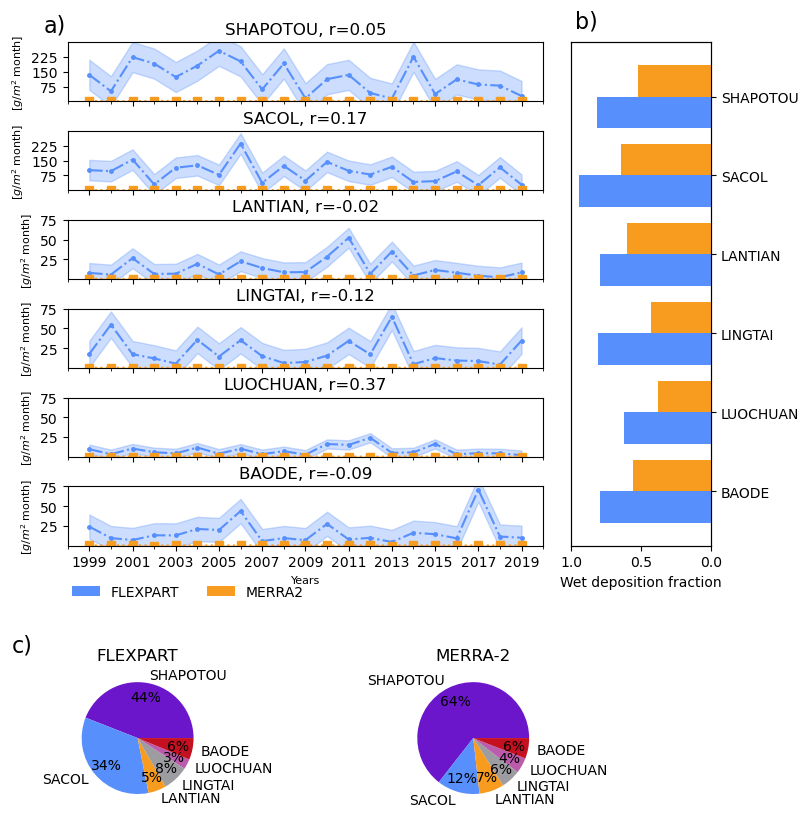

In [14]:

df_tot_merra15mu = df15[[f'total {site}' for site in sites_merra]]
df_tot_flexpart20  =df_depo_flexpart20[[f'{site} total 20micron' for site in locations]]
markers = ['.','s']

frac_wetdep_flexpart=pd.DataFrame(df_depo_flexpart20[[f'total {site} wetdep 20micron' for site in locations]].values/df_tot_flexpart20.values,index=df_depo_flexpart20.index,
             columns=['{} frac wetdep'.format(site) for site in locations]).mean()

frac_wetdep_merra = pd.DataFrame(df15[[f'wetdep {site}' for site in sites_merra]].values/df_tot_merra15mu.values, index=df_tot_merra15mu.index, 
                                    columns=['{} frac wetdep'.format(site) for site in sites_merra]).mean()

# df_tot_merra = std_scale(df_tot_merra)
# df_tot_flexpart = std_scale(df_tot_flexpart)
color=["#5790fc", "#f89c20", "#e42536", "#964a8b", "#9c9ca1", "#7a21dd"]
fig= plt.figure(figsize=(8.3,10))
gs = fig.add_gridspec(9, 4,hspace=0.5,wspace=0.2)
index=0
plt.rc('axes', labelsize=8)
axes = []
ax = fig.add_subplot(gs[index,:3])
ax.set_xticks(df_depo_flexpart.index[::2])

ax.xaxis.set_minor_locator(MultipleLocator(2))

axes.append(ax)
for merra,flexpart in zip(df_tot_merra15mu.items(), df_tot_flexpart20.items()):
    if index > 0:
        ax = fig.add_subplot(gs[index,:3], sharex=ax)
#     ax_1 = ax.twinx()
#     ax.set_xticks(df_depo_flexpart.index[::2])
    flexpart[1].plot(ax=ax, marker='o', linestyle='-.', color="#5790fc",markersize=2.5)
    ax.fill_between(flexpart[1].index, flexpart[1].std()+flexpart[1], flexpart[1]-flexpart[1].std(),alpha=.3,color="#5790fc")
    merra[1].plot(ax=ax,marker='s', linestyle=':', color="#f89c20")
    ax.fill_between(merra[1].index, merra[1].std()+merra[1], merra[1]-merra[1].std(),alpha=.3,color="#f89c20")
    corr = flexpart[1].corr(merra[1])
    ax.set_title(f'{merra[0].split(" ")[1]}, r={corr:.2f}')
    index+=1
    ax.set_ylabel('[$g/m^2 \; \mathrm{month}$]')
    # ax_1.set_ylabel('MERRA2')
    if index > 2:

        ax.set_ylim(0,75)
        ax.set_yticks([25,50,75])
    else:
        ax.set_ylim(0,300)
        ax.set_yticks([75,150,225])
ax.set_xticklabels([str(l) for l in df_depo_flexpart20.index[::2]])
plt.setp(ax.xaxis.get_label(), visible=True, text='Years')

ax = fig.add_subplot(gs[:6,3])
x=np.arange(1,len(frac_wetdep_flexpart)+1)
# ax.invert_yaxis()
ax.set_yticklabels([]) # Hide the left y-axis tick-labels
ax.set_yticks([]) # Hide the left y-axis ticks
ax1 = ax.twinx() # Create a twin x-axis
ax1.barh(x, frac_wetdep_flexpart.values[::-1], height=0.4, color="#5790fc", label='FLEXPART')
ax1.barh(x+0.4, frac_wetdep_merra.values[::-1], height=0.4, color="#f89c20",label='MERRA2')
# ax.barh
# ax.yaxis.set_ticks_position('left')
ax.set_xlim(1,0)
ax1.set_yticks(x+0.2)
ax1.set_yticklabels(sites_merra[::-1])
h,l = ax1.get_legend_handles_labels()
fig.legend(h,l,bbox_to_anchor=(0.27,0.33), frameon=False,loc=10, ncol=2)
# axes.append(ax)

mean_dep_fp=df_depo_flexpart20.mean(axis=0)[[f'{site} total 20micron' for site in locations]]

mean_dep_merra = df15.mean(axis=0)[[f'total {site}' for site in sites_merra]]


ax_p1 = fig.add_subplot(gs[7:,:1])

ax_p2 = fig.add_subplot(gs[7:,2:3])

mean_dep_fp = mean_dep_fp.rename({
    k: k.split(' ')[0] for k in mean_dep_fp.keys()})

mean_dep_merra = mean_dep_merra.rename({
    k: k.split(' ')[-1] for k in mean_dep_merra.keys()})


df_color_fp = mean_dep_fp.index.map(site_color_dict)

df_color_merra = mean_dep_merra.index.map(site_color_dict)
mean_dep_fp.plot.pie(ax=ax_p1,colors=df_color_fp,pctdistance=.74, autopct='%1.0f%%',label='',labeldistance=1.15, title=
                      'FLEXPART')
mean_dep_merra.plot.pie(ax=ax_p2,colors=df_color_fp,pctdistance=.74, autopct='%1.0f%%',label='',labeldistance=1.15, title=

                        'MERRA-2')
# ax_p1.text(0.04,0.9, '')
add_letter(np.array(axes),y=1.18,x=-0.05,zorder=4000)
ax.text(0.03, 1.03,'b)',transform=ax.transAxes, fontsize=16)
ax.set_xlabel('Wet deposition fraction', fontsize=10)
# axes[0].set_xticks(df_depo_flexpart.index[::2])
# axes[0].xaxis.set_minor_locator(MultipleLocator(2))
ax_p1.text(-0.4, 1.12,'c)',transform=ax_p1.transAxes, fontsize=16)

ax = fig.get_axes()[0]
# ax.xaxis.set_ticklabels([(pos,str(i)) for i, pos in zip(df_depo_flexpart.index[::2],ax.get_xticks())])

# plt.setp(, visible=True, text='years')
plt.savefig('FLEXPART_MERRA2_total_depostion_super_coarse.pdf', bbox_inches='tight')
plt.savefig('FLEXPART_MERRA2_total_depostion_super_coarse.png',dpi=300, bbox_inches='tight')